In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import solver
from functools import reduce
from tqdm.notebook import trange
from tqdm.notebook import tqdm

ALPHABET = "abcdefghijklmnopqrstuvwxyz"

In [2]:
def get_letter_tiles(board):
    n = int(np.sqrt(len(board)))
    return [(j, i) for i in range(n) for j in range(n) if board[n*j + i] != " "]

def verrify_all_tiles_used_in_soln(board: str, paths: dict[str, list[list[tuple[int, int]]]]):
    all_letter_tiles = set(get_letter_tiles(board))
    append = lambda a, b: a+b
    union = lambda a, b: set(a).union(set(b))
    return reduce(union, reduce(append, list(paths.values()))) == all_letter_tiles

def verrify_all_letters_used_in_soln(board, soln) -> bool:
    # Does this work for repeated letters?
    return all(any(letter in word for word in soln) for letter in board if letter != " ")

def print_board(board):
    n = int(np.sqrt(len(board)))
    for i in range(n):
        print(board[n*i:n*(i+1)])

def get_word_list(four_letter_min=True) -> list[str]:
    words = []
    with open("words.txt", "r") as f:
        words = [line.strip() for line in f.readlines() if not four_letter_min or len(line.strip()) >= 4]
    return words

def get_word_freq_dict(four_letter_min=True, normalize=True) -> dict[str, float]:
    freqs = {}
    with open("freqs.pkl", "rb") as f:
        freqs = {k: v for k,v in pickle.load(f).items() if not four_letter_min or len(k) >=4}
    if normalize:
        freq_sum = sum(freqs.values())
        return {k: v / freq_sum for k, v in freqs.items()}
    return freqs

def get_unweighted_letter_freq_dict(four_letter_word_min=True) -> dict[str, float]:
    all_words = "".join(get_word_list(four_letter_word_min))
    return {c: all_words.count(c)/len(all_words) for c in ALPHABET}

def get_weighted_letter_freq_dict(four_letter_word_min=True) -> dict[str, float]:
    word_freqs = get_word_freq_dict(four_letter_min=four_letter_word_min)
    letter_freqs = {letter: sum(freq*word.count(letter) for word, freq in word_freqs.items() if letter in word) for letter in ALPHABET}
    return {k: v / sum(letter_freqs.values()) for k, v in letter_freqs.items()}

def plot_letter_freq_comparisons():
    # Get different frequency dicts
    unweighted_letter_freqs_all = get_unweighted_letter_freq_dict(False)
    unweighted_letter_freqs_4plus = get_unweighted_letter_freq_dict()
    weighted_letter_freqs_all = get_weighted_letter_freq_dict(False)
    weighted_letter_freqs_4plus = get_weighted_letter_freq_dict()

    # Plot bar charts
    plt.bar(range(26), [unweighted_letter_freqs_all[c] for c in ALPHABET], alpha=0.25, label="Unweighted (all)")
    plt.bar(range(26), [unweighted_letter_freqs_4plus[c] for c in ALPHABET], alpha=0.25, label="Unweighted (>3)")
    plt.bar(range(26), [weighted_letter_freqs_all[c] for c in ALPHABET], alpha=0.25, label="Weighted (all)")
    plt.bar(range(26), [weighted_letter_freqs_4plus[c] for c in ALPHABET], alpha=0.25, label="Weighted (>3)")
    plt.xticks(range(26), list(ALPHABET))
    plt.xlabel("Letter")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

In [3]:
board = "ab defghi"
print_board(board)
paths = solver.solve(board, return_paths=True)
words = list(paths.keys())
print(verrify_all_letters_used_in_soln(board, words), verrify_all_tiles_used_in_soln(board, paths))

ab 
def
ghi
True True


In [4]:
letter_freq_dict = get_weighted_letter_freq_dict()
letter_freq_list = [letter_freq_dict[c] for c in ALPHABET]
word_freqs = get_word_freq_dict()

In [5]:
class Solution:
    LOW_FREQ_THRESHOLD = 5e-6
    def __init__(self, grid_str, soln_words=None):
        self.grid_str = grid_str

        # Get solution
        if soln_words:
            self.word_paths = soln_words
            self.all_words = soln_words
        else:
            self.all_words = solver.solve(grid_str)

        if self.all_words == []:
            self.all_words = [""]
            
        # Separate required/bonus words by word frequency
        self.required_words = [word for word in self.all_words if word_freqs[word] > self.LOW_FREQ_THRESHOLD]
        self.bonus_words = [word for word in self.all_words if not word in self.required_words]
        self.num_all_words = len(self.all_words)
        self.num_required_words = len(self.required_words)
        self.num_bonus_words = len(self.bonus_words)

        # Get word lengths
        self.required_word_lengths = [len(word) for word in self.required_words]
        self.bonus_word_lengths = [len(word) for word in self.bonus_words]
        self.max_word_length = max(self.required_word_lengths) if len(self.required_word_lengths) > 0 else None

        # Get word frequencies
        self.required_word_freqs = [word_freqs[word] for word in self.required_words]
        self.bonus_word_freqs = [word_freqs[word] for word in self.bonus_words]
        self.min_required_word_freq = min(self.required_word_freqs) if len(self.required_word_freqs) > 0 else None
        self.max_required_word_freq = max(self.required_word_freqs) if len(self.required_word_freqs) > 0 else None
        self.avg_required_word_freq = np.mean(self.required_word_freqs) if len(self.required_word_freqs) > 0 else None


In [6]:
def generate_trial_board(n):
    return "".join(random.choices(ALPHABET, weights=letter_freq_list, k=n**2))

def generate_puzzle(
        n, 
        min_longest_word_len=None,
        min_word_count=None,
        min_word_freq=None,
        enforce_all_tiles_used=True, 
        holes=None):
    while True:
        # Get a random board
        board = generate_trial_board(n)
        
        # Make any holes
        if holes:
            for h in holes:
                board = board[:h] + " " + board[h+1:]

        # Get solution
        word_paths = solver.solve(board, return_paths=True)
        soln_words = list(word_paths.keys())

        solution = Solution(board, soln_words)
        required_word_paths = {word: paths for word, paths in word_paths.items() if word in solution.required_words}

        # Check any required words exist
        if len(solution.required_words) == 0:
            continue
        
        # Check all letters used
        if enforce_all_tiles_used and not verrify_all_tiles_used_in_soln(board, required_word_paths):
            continue
        
        # check word count
        if min_word_count and len(soln_words) < min_word_count:
            continue

        # check min word frequency
        if min_word_freq and any(word_freqs[word] < min_word_freq for word in soln_words):
            continue

        # Check longest word length
        if min_longest_word_len and max(len(word) for word in soln_words) < min_longest_word_len:
            continue

        return solution

srus
lsow
drse
lcih

Total words: 51
Mean word frequency: 0.000148
Required words: 20
Bonus words: 31
Mean high-frequency word frequency: 0.000148
['rose', 'rows', 'sword', 'swords', 'sour', 'sous', 'ours', 'owes', 'weird', 'world', 'worlds', 'word', 'words', 'worse', 'rise', 'cross', 'crow', 'cries', 'heir', 'heirs']


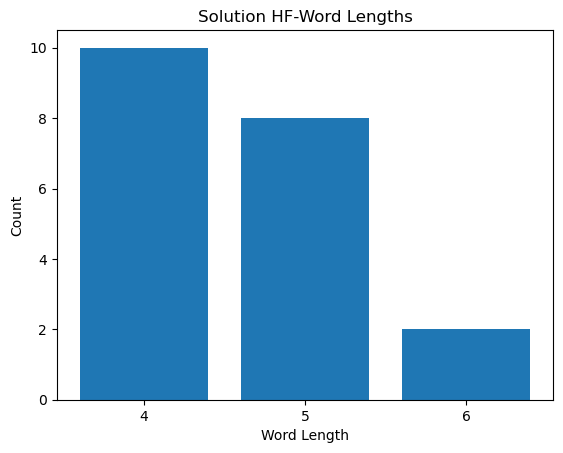

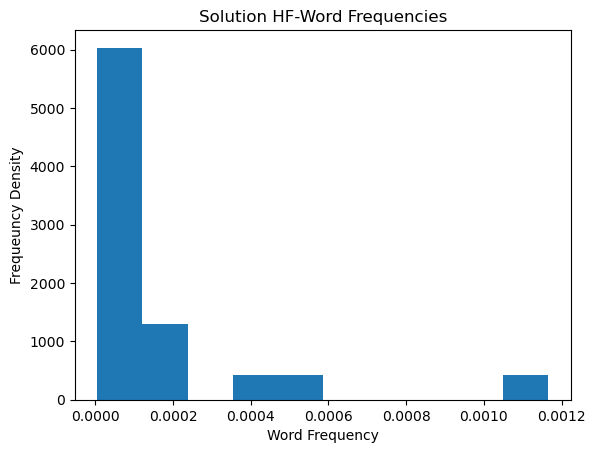

In [7]:
solution = generate_puzzle(4)
board = solution.grid_str
soln_words = solution.all_words

print_board(board)
print(f"\nTotal words: {solution.num_all_words}")
print(f"Mean word frequency: {solution.avg_required_word_freq:.6f}")

print(f"Required words: {solution.num_required_words}")
print(f"Bonus words: {solution.num_bonus_words}")
print(f"Mean high-frequency word frequency: {solution.avg_required_word_freq:.6f}")

print(solution.required_words)

# plt.bar(range(4, max_word_len+1), [soln_word_lens.count(i) for i in range(4, max_word_len+1)])
# plt.xticks(range(4, max_word_len+1))
# plt.xlabel("Word Length")
# plt.ylabel("Count")
# plt.title("Solution Word Lengths")
# plt.show()

# plt.hist(soln_word_freqs, density=True)
# plt.xlabel("Word Frequency")
# plt.ylabel("Frequeuncy Density")
# plt.title("Solution Word Frequencies")
# plt.show()

plt.bar(range(4, solution.max_word_length+1), [solution.required_word_lengths.count(i) for i in range(4, solution.max_word_length+1)])
plt.xticks(range(4, solution.max_word_length+1))
plt.xlabel("Word Length")
plt.ylabel("Count")
plt.title("Solution HF-Word Lengths")
plt.show()

plt.hist(solution.required_word_freqs, density=True)
plt.xlabel("Word Frequency")
plt.ylabel("Frequeuncy Density")
plt.title("Solution HF-Word Frequencies")
plt.show()


In [ ]:
puzzles = dict()
try:
    for n in [3,4,5]:
        with open(f"puzzles_{n}.pkl", "rb") as f:
            puzzles[n] = pickle.load(f)
except:
    puzzles = {3: [], 4: [], 5: []}
print(f"Starting with {len(puzzles[3])} puzzles")
best_word_freq_sum = 0
while True:
    try:
        for n in puzzles.keys():
            solution = generate_puzzle(n)
            board = solution.grid_str
            soln_words = solution.all_words
            puzzles[n].append(board)

            with open(f"puzzles_{n}.pkl", "wb") as f:
                pickle.dump(puzzles[n], f)

            # print progress for n=4
            if n != 4: continue 
            print_latest_board = False
            if sum(solution.required_word_freqs) > best_word_freq_sum:
                best_word_freq_sum = sum(solution.required_word_freqs)
                best_word_freq_sum_board = board
                print_latest_board = True

            # if solution.max_word_length > best_max_word_len:
            #     best_max_word_len = solution.max_word_length
            #     best_max_word_len_board = board
            #     print_latest_board = True

            # if solution.avg_required_word_freq > best_avg_word_freq:
            #     best_avg_word_freq = solution.avg_required_word_freq
            #     best_avg_word_freq_board = board
            #     print_latest_board = True
            
            if print_latest_board:
                print(f"{board}")
                print(f"\t Required words: {solution.num_required_words}")
                print(f"\t Bonus words:    {solution.num_bonus_words}")
                print(f"\t Max word len:   {solution.max_word_length}")
                print(f"\t Avg word freq:  {solution.avg_required_word_freq:.6f}")
                print(f"\t Word freq sum:  {sum(solution.required_word_freqs):.6f}")

    except:
        pass

Starting with 25297 puzzles
anaerephaialrume
	 Required words: 33
	 Bonus words:    52
	 Max word len:   6
	 Avg word freq:  0.000092
	 Word freq sum:  0.003020
relcdpaeenhrltla
	 Required words: 73
	 Bonus words:    110
	 Max word len:   8
	 Avg word freq:  0.000144
	 Word freq sum:  0.010536


In [8]:
puzzles = dict()
for n in [3,4,5]:
        with open(f"puzzles_{n}.pkl", "rb") as f:
                puzzles[n] = pickle.load(f)

solutions = dict()
for n in [3,4,5]:
        print(f"Solving {len(puzzles[n])} {n}x{n} puzzles...")
        solutions[n] = []
        for i in trange(len(puzzles[n])):
                solutions[n].append(Solution(puzzles[n][i]))

#solutions = {k: [Solution(puzzle) for puzzle in puzzles[k]] for k in puzzles.keys()}

Solving 22656 3x3 puzzles...


  0%|          | 0/22656 [00:00<?, ?it/s]

Solving 22591 4x4 puzzles...


  0%|          | 0/22591 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
from scipy.optimize import curve_fit
from scipy.special import gamma

def max_boltz(x, a):
    return np.sqrt(2 / np.pi) * (x*x / a**3) * np.exp(-x*x/(2*a*a))

def rayleigh(x, sigma):
    return x * np.exp(-x*x/(2*sigma*sigma)) / (sigma*sigma)

def power_gauss(x, a, sigma):
    return np.power(x, a-1)*np.exp(-x*x/(2*sigma*sigma)) / (np.power(2, a/2 - 1)*np.power(sigma, a)*gamma(a/2))

req_word_counts = [sol.num_required_words for sol in puzzles[4]]
x = np.array(list(range(1, max(req_word_counts))))
y = np.array([len([count for count in req_word_counts if count == i])/len(req_word_counts) for i in x])

(a), _ = curve_fit(max_boltz, x, y)
(sigma), _ = curve_fit(rayleigh, x, y)
(a2, sigma2), _ = curve_fit(power_gauss, x, y, p0=(1.5, 50))

mb_pred = [max_boltz(i, a) for i in x]
rl_pred = [rayleigh(i, sigma) for i in x]
pg_pred = [power_gauss(i, a2, sigma2) for i in x]

plt.figure().set_size_inches(20, 10, forward=True)
plt.bar(x, y)
plt.plot(x, mb_pred, label=f"Maxwell-Boltzmann (a = {a[0]:.2f})")
plt.plot(x, rl_pred, label=f"Rayleigh (sigma={sigma[0]:.2f})")
plt.plot(x, pg_pred, label=f"Power-Gauss (a={a2:.2f}, sigma={sigma2:.2f})")
plt.legend()
plt.show()

print(sum(mb_pred), sum(rl_pred), sum(pg_pred))

AttributeError: 'str' object has no attribute 'num_required_words'

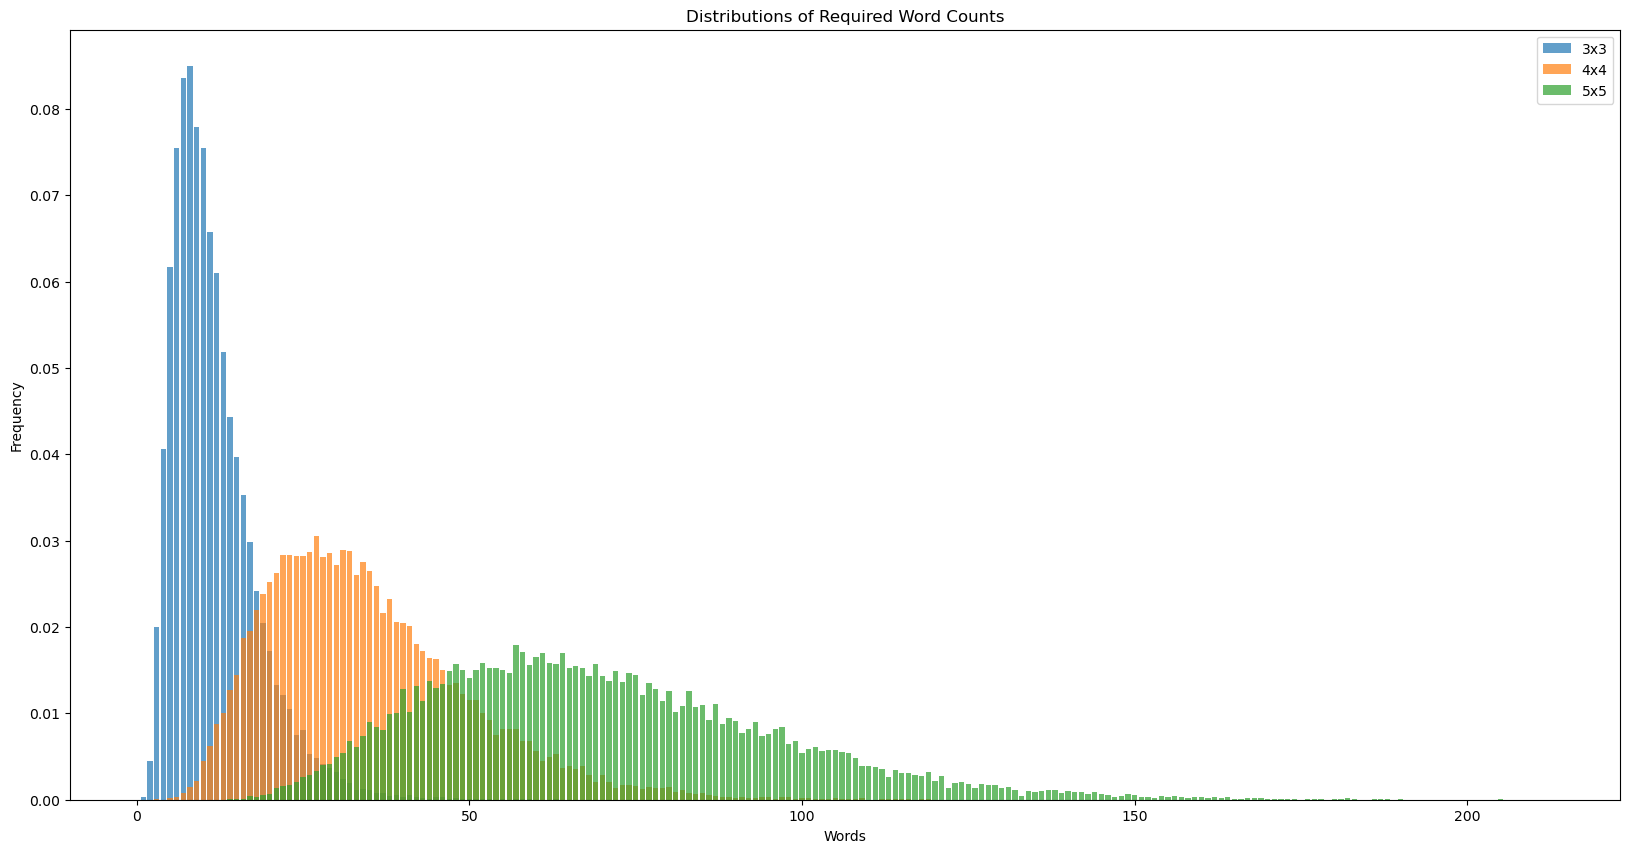

In [ ]:
req_word_counts = [sol.num_required_words for sol in puzzles[3]]
x = list(range(1, max(req_word_counts)))
y = [len([count for count in req_word_counts if count == i])/len(req_word_counts) for i in x]
plt.figure().set_size_inches(20, 10, forward=True)
plt.bar(x, y, alpha=0.7, label="3x3")

req_word_counts = [sol.num_required_words for sol in puzzles[4]]
x = list(range(1, max(req_word_counts)))
y = [len([count for count in req_word_counts if count == i])/len(req_word_counts) for i in x]
plt.bar(x, y, alpha=0.7, label="4x4")

req_word_counts = [sol.num_required_words for sol in puzzles[5]]
x = list(range(1, max(req_word_counts)))
y = [len([count for count in req_word_counts if count == i])/len(req_word_counts) for i in x]
plt.bar(x, y, alpha=0.7, label="5x5")

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Distributions of Required Word Counts")
plt.legend()
plt.show()

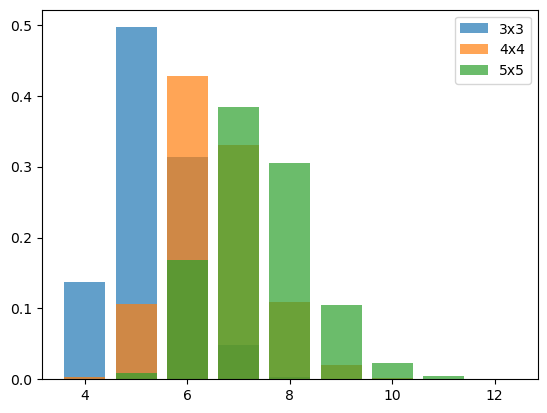

In [ ]:
max_word_lens = [sol.max_word_length for sol in puzzles[3]]
x = list(range(4, max(max_word_lens)))
y = [len([l for l in max_word_lens if l == i])/len(max_word_lens) for i in x]
plt.bar(x, y, alpha=0.7, label="3x3")

max_word_lens = [sol.max_word_length for sol in puzzles[4]]
x = list(range(4, max(max_word_lens)))
y = [len([l for l in max_word_lens if l == i])/len(max_word_lens) for i in x]
plt.bar(x, y, alpha=0.7, label="4x4")

max_word_lens = [sol.max_word_length for sol in puzzles[5]]
x = list(range(4, max(max_word_lens)))
y = [len([l for l in max_word_lens if l == i])/len(max_word_lens) for i in x]
plt.bar(x, y, alpha=0.7, label="5x5")

plt.legend()
plt.show()

0.04099139612732129

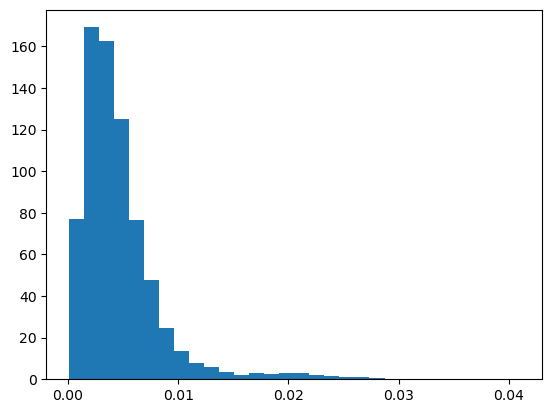

In [ ]:
plt.hist([sum(sol.required_word_freqs) for sol in puzzles[4]], density=True, bins=30)
max([sum(sol.required_word_freqs) for sol in puzzles[4]])